In [ ]:
# | hide
%load_ext autoreload
%autoreload 2

# Hello World

## RAG example

Working with stringdale Involves three steps:

* Bringing your functions
* Defining a diagram schema
* Running the a diagram instance

Lets look at an example step by step.

### Bring your functions

First, let us import some basic llm functions, we built some thin wrappers:

* `Chat` wraps [instructor](https://python.useinstructor.com/) using [jinja2](https://jinja.palletsprojects.com/en/stable/) to make templating prompts simpler.
* `ChromaClient` wraps [ChromaDB](https://docs.trychroma.com/docs/overview/introduction) so that are queries are returned as a list of dicts.

These functions are just for instruction purposes, you should build your own around the SDKs of the tools suited to your specific LLM needs.

In [ ]:
from stringdale.chat import Chat
from stringdale.db import ChromaClient


Lets make an example vector db:

In [ ]:
chroma_client = ChromaClient()

dog_docs = [
    {
        'id': 'dog1',
        'text': 'The Golden Retriever is a friendly, intelligent breed known for its golden coat. They make excellent family pets and are great with children.',
        'metadata': {'breed': 'Golden Retriever'}
    },
    {
        'id': 'dog2', 
        'text': 'German Shepherds are loyal, protective dogs often used in police work. They are highly trainable and good at various tasks.',
        'metadata': {'breed': 'German Shepherd'}
    },
    {
        'id': 'dog3',
        'text': 'The Golden Retriever is a friendly, intelligent breed with a beautiful golden coat. They are wonderful family pets that get along well with kids.',
        'metadata': {'breed': 'Golden Retriever'}  
    },
    {
        'id': 'dog4',
        'text': 'Huskies are energetic working dogs bred for cold climates. They have thick fur and often blue eyes.',
        'metadata': {'breed': 'Husky'}
    },
    {
        'id': 'dog5',
        'text': 'Siberian Huskies are active working dogs that thrive in cold weather. They are known for their thick coats and striking blue eyes.',
        'metadata': {'breed': 'Husky'} 
    }
]

chroma_client.add_collection("dog_docs",exists_ok=True)
chroma_client.upsert(collection_name="dog_docs",docs=dog_docs)
chroma_client.query(query='the name of the dog is german something...',collection_name='dog_docs',k=3)

[{'id': 'dog2',
  'text': 'German Shepherds are loyal, protective dogs often used in police work. They are highly trainable and good at various tasks.',
  'metadata': {'breed': 'German Shepherd'},
  'distance': 1.1108226776123047},
 {'id': 'dog4',
  'text': 'Huskies are energetic working dogs bred for cold climates. They have thick fur and often blue eyes.',
  'metadata': {'breed': 'Husky'},
  'distance': 1.409012794494629},
 {'id': 'dog1',
  'text': 'The Golden Retriever is a friendly, intelligent breed known for its golden coat. They make excellent family pets and are great with children.',
  'metadata': {'breed': 'Golden Retriever'},
  'distance': 1.4541898965835571}]

In [ ]:
rag_chat = Chat(
    model='gpt-4o-mini',
    messages=[
        {'role':'system','content':'''
            You are a helpful assistant that answers questions about dogs.
            I found the following documents that may be relevant to the user's question:
            {% for doc in docs %}
            {{doc['text']}}
            {% endfor %}
            '''},
        {'role':'user','content':'{{question}}'},
    ]
)
rag_chat

Chat(model='gpt-4o-mini', required_keys={'question', 'docs'}, seed=42)

In [ ]:
await rag_chat(question='the name of the dog is german something...',docs=[
    {'text': 'German Shepherds are loyal, protective dogs often used in police work. They are highly trainable and good at various tasks.'}
])

{'role': 'assistant',
 'content': 'It sounds like you might be referring to the "German Shepherd." German Shepherds are well-known for their loyalty, intelligence, and versatility, often serving in police and military roles. If you have any specific questions about them or need more information, feel free to ask!',
 'meta': {'input_tokens': 70, 'output_tokens': 54}}

### Define your diagram

In [ ]:
from stringdale import V,E,Define

We define a diagram as follows:

In [ ]:
with Define('RAG Agent',type='flow') as RAG:

    # each node has a name and an optional function
    V('get_docs',chroma_client.query)
    V('chat',rag_chat)
    # nodes that have no function are called "pass through" nodes
    # they simply collect outputs passed to them into a dict
    # Start and End are created automatically as pass through nodes if not defined otherwise
    V('Start')
    V('End')
    
    # we can define edges using the E function
    # edges are defined via a 'source->target(port_mapping)' syntax
    # we cover the port mapping syntax in depth in the next tutorial
    E('Start->get_docs(**)')   
    E('get_docs->chat(docs=.)')
    E('Start->chat(question=query)')
    E('chat->End')

The `RAG` object we got from the `Define` context manager is a Diagram Schema

In [ ]:
RAG

<stringdale.base.DiagramSchema RAG Agent @0x1105113a0>

You can draw the diagram using the draw method

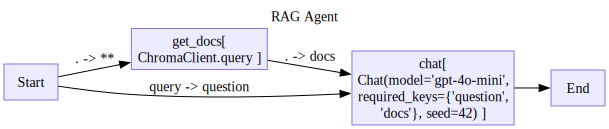

In [ ]:
RAG.draw()

You can also define incoming and outgoing edges within the node definition:

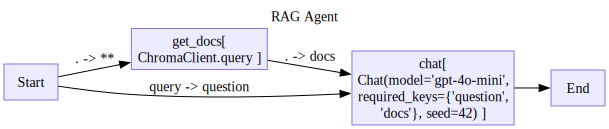

In [ ]:
with Define('RAG Agent',type='flow') as RAG:
    V('get_docs',chroma_client.query,
        #inputs are defined using the 'source(port_mapping)' syntax
        #outputs can be likewise defined using the 'target(port_mapping) syntax
        inputs=['Start(**)'],
    )
    V('chat',rag_chat,
        inputs=['get_docs(docs)','Start(question=query)'],
        outputs=['End']
    )
    
RAG.draw()

### Running a diagram

We can get a instance of a diagram that can be run by calling the schema object.

In [ ]:
d = RAG()
d


<stringdale.base.Diagram>

The most common way to run a diagram is using the `run` or `arun` methods, which allows us to handle traces of each nodes however we want within the for loop, avoiding the need for complex callback mechanisms.

In [ ]:
for trace in d.run({'query':'tell me some stuff about golden retrievers','collection_name':'dog_docs','k':2}):
    # we can use pprint for easy debugging
    trace.pprint()
    pass

# after running a diagram, we can access the output using the output attribute
d.output


{'role': 'assistant',
 'content': 'Golden Retrievers are a popular dog breed known for their friendly and intelligent nature. Here are some key points about them:\n\n1. **Temperament**: Golden Retrievers are known for their friendly and gentle demeanor. They are highly sociable and get along well with children and other pets, making them excellent family dogs.\n\n2. **Intelligence**: This breed is highly intelligent and eager to please, which makes them easy to train. They excel in obedience training and are often used as service dogs due to their ability to learn commands quickly.\n\n3. **Physical Characteristics**: Golden Retrievers have a distinctive golden coat that is water-repellent, aiding in outdoor activities. Their fur can vary in shade from light to dark golden.\n\n4. **Exercise Needs**: They are active and energetic dogs that require regular exercise. Daily walks, playtime, and mental stimulation are essential to keep them healthy and happy.\n\n5. **Health Considerations**:

## The Details

Nodes can be any callable, including function objects and class methods.
Nodes should be pure functions, meaning that they do not remember how they were called in the past.

For rare use-cases requiring stateful nodes, see the stateful nodes tutorial.

In [ ]:
def add(a,b):
    return a+b

class Pow():
    def __init__(self,power):
        self.power = power
    def __call__(self,a):
        return a**self.power
    def __str__(self):
        return f'Pow({self.power})'

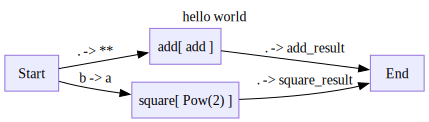

In [ ]:
with Define('hello world') as Schema:
    
    V('add',add,inputs=['Start(**=.)'],outputs=['End(add_result=.)'])
    V('square',Pow(2),inputs=['Start(a=b)'],outputs=['End(square_result=.)'])
Schema.draw()

## Different ways of Running Diagrams

We can run diagrams end-to-end like so:

### running without side effects

In [ ]:
d=Schema()
d.run_all({'a':1,'b':2})

{'square_result': 4, 'add_result': 3}

### Running with synchronous side effects

but in most cases, we would like to monitor the traces of each nodes, which is why we usually run it like so:

In [ ]:
d=Schema()
for trace in d.run({'a':1,'b':2}):
    # put here any side affect you want
    trace.pprint()

Accessing the output via the output attribute of our diagram

In [ ]:
d.output

{'add_result': 3, 'square_result': 4}

### Running async functions is transparent

stringdale works with transparently with both sync and async functions.
For example:

In [ ]:
import time
import timeit
import asyncio

In [ ]:
async def async_add(a,b):
    await asyncio.sleep(0.1)
    return a+b

class AsyncPow():
    def __init__(self,power):
        self.power = power
    async def __call__(self,a):
        await asyncio.sleep(0.1)
        return a**self.power
    def __str__(self):
        return f'AsyncPow({self.power})'

Can be used exactly the same as the sync versions:

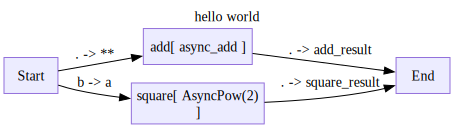

In [ ]:
with Define('hello world') as Schema:
    V('add',async_add,inputs=['Start(**=.)'],outputs=['End(add_result=.)'])
    V('square',AsyncPow(2),inputs=['Start(a=b)'],outputs=['End(square_result=.)'])
Schema.draw()

In [ ]:
d=Schema()
start_time = timeit.default_timer()
for trace in d.run({'a':1,'b':2}):
    trace.pprint()
end_time = timeit.default_timer()


Note that these functions were run asynchronously

In [ ]:
print(f'Time taken: {end_time-start_time:.2f} seconds')


Time taken: 0.12 seconds


### Async side effects

If we want some asynchronous side effects, like logging our traces to our server, for example with this mock class:

In [ ]:
class Logserver():
    def __init__(self):
        self.logs=[]
    async def log(self,trace):
        self.logs.append(trace)
        await asyncio.sleep(0.1)
        return trace.pretty_name()
        

We can use the asynchronous `arun` method.

In [ ]:
logserver = Logserver()
logs = []

start_time = timeit.default_timer()

async for trace in d.arun({'a':1,'b':2}):
    log_task = logserver.log(trace)
    logs.append(log_task)

res = await asyncio.gather(*logs)

end_time = timeit.default_timer()
res

['Start', 'square', 'add', 'End']

In [ ]:
print(f'Time taken: {end_time-start_time:.2f} seconds')

Time taken: 0.20 seconds
